## 1. Setup and Imports

In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import os
from collections import Counter
import heapq
from sklearn.cluster import KMeans
import pickle
from tqdm import tqdm
import time

from sklearn.ensemble import RandomForestClassifier
import joblib
# Set random seed for reproducibility
np.random.seed(42)

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

## 2. Configuration

Update these settings based on your video and requirements.

In [33]:
# Video properties 
VIDEO_NAME = "Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv"  # For saving results
ORIGINAL_WIDTH = 1920
ORIGINAL_HEIGHT = 1080
FPS = 120

# Processing parameters
BLOCK_SIZE = 8  # 8x8 blocks (standard)
TARGET_RESOLUTION = (352, 288)  # Downsample to CIF for faster processing
# Alternative: (1920, 1080) for full HD, (640, 480) for intermediate

# RVQ parameters
CODEBOOK_SIZE = 256  # Number of codewords per stage
NUM_STAGES = 3  # Number of RVQ refinement stages
MAX_ITERATIONS = 100  # For codebook training

# Number of frames
NUM_FRAMES = 100

print("Configuration:")
print(f"  Video: {VIDEO_NAME}")
print(f"  Original Resolution: {ORIGINAL_WIDTH}×{ORIGINAL_HEIGHT}")
print(f"  Target Resolution: {TARGET_RESOLUTION[0]}×{TARGET_RESOLUTION[1]}")
print(f"  Block Size: {BLOCK_SIZE}×{BLOCK_SIZE}")
print(f"  RVQ Stages: {NUM_STAGES}")
print(f"  Codebook Size: {CODEBOOK_SIZE}")
print(f"  Frames to Process: {NUM_FRAMES}")

Configuration:
  Video: Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv
  Original Resolution: 1920×1080
  Target Resolution: 352×288
  Block Size: 8×8
  RVQ Stages: 3
  Codebook Size: 256
  Frames to Process: 100


## 3. Load Pre-extracted YUV Frames

If you've already loaded frames using `working_with_yuv.ipynb`, you can either:
1. Copy the `yuv_frames` variable here
2. Re-load from the YUV file
3. Load from saved images

In [34]:
def load_yuv420_file(filepath, width, height, num_frames=None, start_frame=0):
    """
    Load YUV 4:2:0 file.
    """
    y_size = width * height
    u_size = (width // 2) * (height // 2)
    v_size = u_size
    frame_size = y_size + u_size + v_size
    
    file_size = os.path.getsize(filepath)
    total_frames = file_size // frame_size
    
    print(f"\nLoading YUV file: {filepath}")
    print(f"  File size: {file_size / (1024*1024):.2f} MB")
    print(f"  Total frames available: {total_frames}")
    
    if num_frames is None:
        num_frames = total_frames - start_frame
    else:
        num_frames = min(num_frames, total_frames - start_frame)
    
    print(f"  Loading frames {start_frame} to {start_frame + num_frames - 1}")
    
    frames_yuv = []
    
    with open(filepath, 'rb') as f:
        f.seek(start_frame * frame_size)
        
        for i in tqdm(range(num_frames), desc="Loading frames"):
            frame_data = f.read(frame_size)
            
            if len(frame_data) < frame_size:
                print(f"  Warning: Incomplete frame {i}, stopping.")
                break
            
            frame_array = np.frombuffer(frame_data, dtype=np.uint8)
            
            y = frame_array[:y_size].reshape(height, width)
            u = frame_array[y_size:y_size+u_size].reshape(height//2, width//2)
            v = frame_array[y_size+u_size:].reshape(height//2, width//2)
            
            frames_yuv.append({
                'Y': y.astype(np.float32),
                'U': u.astype(np.float32),
                'V': v.astype(np.float32)
            })
    
    print(f"Successfully loaded {len(frames_yuv)} frames")
    return frames_yuv


# Load YUV frames
YUV_FILE_PATH = "Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv"

if os.path.exists(YUV_FILE_PATH):
    yuv_frames = load_yuv420_file(
        YUV_FILE_PATH,
        width=ORIGINAL_WIDTH,
        height=ORIGINAL_HEIGHT,
        num_frames=NUM_FRAMES,
        start_frame=0
    )
else:
    print(f" File not found: {YUV_FILE_PATH}")


Loading YUV file: Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv
  File size: 1779.79 MB
  Total frames available: 600
  Loading frames 0 to 99


Loading frames: 100%|██████████| 100/100 [00:00<00:00, 148.36it/s]


Successfully loaded 100 frames


## 4. Preprocessing Module

In [35]:
class VideoPreprocessor:
    """
    Handles video preprocessing for RVQ compression.
    """
    
    def __init__(self, block_size: int = 8, target_resolution: Tuple[int, int] = None):
        self.block_size = block_size
        self.target_resolution = target_resolution
    
    def resize_yuv_frames(self, yuv_frames: List[Dict], 
                         target_size: Tuple[int, int]) -> List[Dict]:
        """
        Resize YUV frames to target resolution.
        """
        print(f"\nResizing frames to {target_size[0]}×{target_size[1]}...")
        resized_frames = []
        
        for frame_yuv in tqdm(yuv_frames, desc="Resizing"):
            # Resize Y channel
            y_resized = cv2.resize(
                frame_yuv['Y'].astype(np.float32),
                target_size,
                interpolation=cv2.INTER_LINEAR
            )
            
            # Resize U and V channels (half resolution for 4:2:0)
            u_size = (target_size[0] // 2, target_size[1] // 2)
            u_resized = cv2.resize(
                frame_yuv['U'].astype(np.float32),
                u_size,
                interpolation=cv2.INTER_LINEAR
            )
            v_resized = cv2.resize(
                frame_yuv['V'].astype(np.float32),
                u_size,
                interpolation=cv2.INTER_LINEAR
            )
            
            resized_frames.append({
                'Y': y_resized,
                'U': u_resized,
                'V': v_resized
            })
        
        print(f" Resized {len(resized_frames)} frames")
        return resized_frames
    
    def partition_into_blocks(self, frame: np.ndarray) -> np.ndarray:
        """
        Partition a frame into non-overlapping blocks.
        """
        height, width = frame.shape
        bs = self.block_size
        
        # Ensure dimensions are divisible by block_size
        h_blocks = height // bs
        w_blocks = width // bs
        
        # Truncate if needed
        frame = frame[:h_blocks*bs, :w_blocks*bs]
        
        # Reshape into blocks
        blocks = frame.reshape(h_blocks, bs, w_blocks, bs)
        blocks = blocks.swapaxes(1, 2)
        
        return blocks
    
    def blocks_to_frame(self, blocks: np.ndarray) -> np.ndarray:
        """
        Reconstruct frame from blocks.
        """
        h_blocks, w_blocks, bs, _ = blocks.shape
        blocks = blocks.swapaxes(1, 2)
        frame = blocks.reshape(h_blocks * bs, w_blocks * bs)
        return frame


# Initialize preprocessor
preprocessor = VideoPreprocessor(
    block_size=BLOCK_SIZE,
    target_resolution=TARGET_RESOLUTION
)

## 5. Apply Preprocessing

In [36]:
# Resize frames if needed
if TARGET_RESOLUTION != (ORIGINAL_WIDTH, ORIGINAL_HEIGHT):
    yuv_frames_processed = preprocessor.resize_yuv_frames(yuv_frames, TARGET_RESOLUTION)
else:
    yuv_frames_processed = yuv_frames
    print(" Using original resolution (no resizing)")

print(f"\nProcessed {len(yuv_frames_processed)} frames")
print(f"Y channel shape: {yuv_frames_processed[0]['Y'].shape}")
print(f"U channel shape: {yuv_frames_processed[0]['U'].shape}")
print(f"V channel shape: {yuv_frames_processed[0]['V'].shape}")


Resizing frames to 352×288...


Resizing: 100%|██████████| 100/100 [00:00<00:00, 192.27it/s]

 Resized 100 frames

Processed 100 frames
Y channel shape: (288, 352)
U channel shape: (144, 176)
V channel shape: (144, 176)


## 6. Extract Training Blocks

Extract blocks from Y channel for codebook training.

In [37]:
print("\nExtracting training blocks from Y channel...")

all_training_blocks = []

for frame_yuv in tqdm(yuv_frames_processed, desc="Extracting blocks"):
    y_channel = frame_yuv['Y']
    blocks = preprocessor.partition_into_blocks(y_channel)
    
    # Flatten blocks for training
    h_blocks, w_blocks, bs, _ = blocks.shape
    for i in range(h_blocks):
        for j in range(w_blocks):
            all_training_blocks.append(blocks[i, j])

training_blocks = np.array(all_training_blocks)

print(f"\n Extracted {training_blocks.shape[0]} training blocks")
print(f"   Block shape: {training_blocks.shape[1:]}")
print(f"   Total training samples: {training_blocks.shape[0]}")
print(f"   Memory size: {training_blocks.nbytes / (1024*1024):.2f} MB")


Extracting training blocks from Y channel...


Extracting blocks: 100%|██████████| 100/100 [00:00<00:00, 1044.27it/s]


 Extracted 158400 training blocks
   Block shape: (8, 8)
   Total training samples: 158400
   Memory size: 38.67 MB


## 7. Visualize Sample Frames

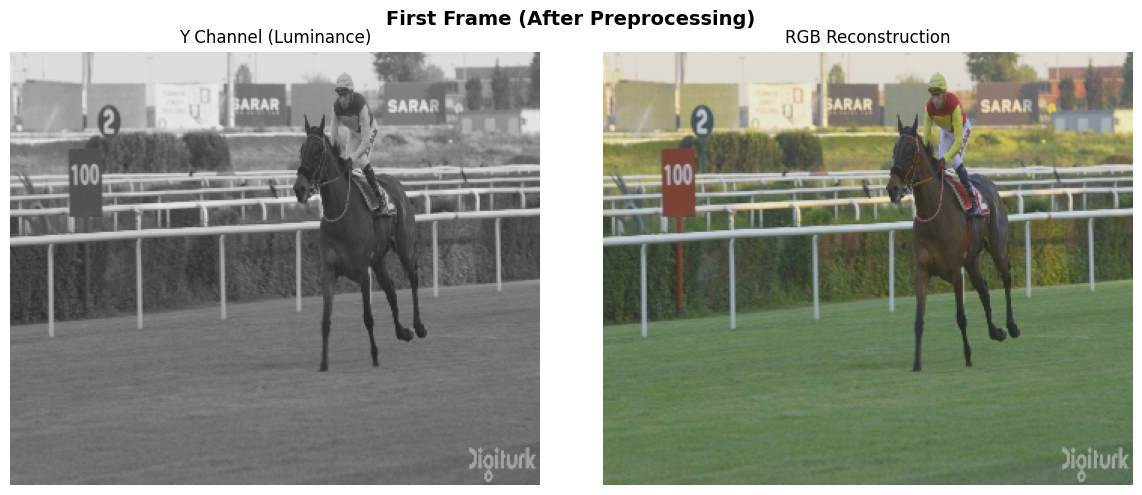

In [38]:
def visualize_yuv_frame(yuv_dict, title="Frame"):
    """
    Visualize Y channel and RGB reconstruction.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Y channel
    axes[0].imshow(yuv_dict['Y'], cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Y Channel (Luminance)')
    axes[0].axis('off')
    
    # RGB reconstruction
    y = np.clip(yuv_dict['Y'], 0, 255).astype(np.uint8)
    u = np.clip(yuv_dict['U'], 0, 255).astype(np.uint8)
    v = np.clip(yuv_dict['V'], 0, 255).astype(np.uint8)
    
    height, width = y.shape
    u_up = cv2.resize(u, (width, height), interpolation=cv2.INTER_LINEAR)
    v_up = cv2.resize(v, (width, height), interpolation=cv2.INTER_LINEAR)
    
    yuv = cv2.merge([y, u_up, v_up])
    rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    
    axes[1].imshow(rgb)
    axes[1].set_title('RGB Reconstruction')
    axes[1].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize first frame
if len(yuv_frames_processed) > 0:
    visualize_yuv_frame(yuv_frames_processed[0], title="First Frame (After Preprocessing)")

## 8. RVQ Encoder Implementation

In [39]:
class RVQEncoder:
    """
    Residual Vector Quantization Encoder.
    """
    
    def __init__(self, codebook_size: int = 256, num_stages: int = 3, 
                 vector_dim: int = 64, max_iterations: int = 100):
        self.codebook_size = codebook_size
        self.num_stages = num_stages
        self.vector_dim = vector_dim
        self.max_iterations = max_iterations
        self.codebooks = []
        
    def train_codebook_lbg(self, training_vectors: np.ndarray, 
                           codebook_size: int = None) -> np.ndarray:
        """
        Train codebook using LBG algorithm (K-means).
        """
        if codebook_size is None:
            codebook_size = self.codebook_size
        
        print(f"  Training codebook: {codebook_size} codewords")
        
        kmeans = KMeans(
            n_clusters=codebook_size,
            max_iter=self.max_iterations,
            random_state=42,
            n_init=10,
            verbose=0
        )
        
        kmeans.fit(training_vectors)
        return kmeans.cluster_centers_
    
    def train_codebook_kmeans_plus(self, training_vectors: np.ndarray,
                                   codebook_size: int = None) -> np.ndarray:
        """
        Train codebook with K-means++ initialization.
        """
        if codebook_size is None:
            codebook_size = self.codebook_size
        
        print(f"  Training codebook: {codebook_size} codewords (K-means++)")
        
        kmeans = KMeans(
            n_clusters=codebook_size,
            init='k-means++',
            max_iter=self.max_iterations,
            random_state=42,
            n_init=1,
            verbose=0
        )
        
        kmeans.fit(training_vectors)
        return kmeans.cluster_centers_
    
    def find_nearest_codeword(self, vector: np.ndarray, 
                             codebook: np.ndarray) -> Tuple[int, np.ndarray]:
        """
        Find nearest codeword using Euclidean distance.
        """
        distances = np.linalg.norm(codebook - vector, axis=1)
        index = np.argmin(distances)
        return index, codebook[index]
    
    def train_multistage_codebooks(self, training_blocks: np.ndarray,
                                   use_kmeans_plus: bool = False):
        """
        Train all RVQ stage codebooks.
        """
        print(f"\n{'='*60}")
        print(f"Training {self.num_stages}-stage RVQ Codebooks")
        print(f"{'='*60}")
        print(f"Training samples: {training_blocks.shape[0]}")
        print(f"Codebook size: {self.codebook_size}")
        print(f"Method: {'K-means++' if use_kmeans_plus else 'LBG (K-means)'}")
        
        # Flatten blocks
        num_blocks = training_blocks.shape[0]
        training_vectors = training_blocks.reshape(num_blocks, -1)
        
        self.codebooks = []
        residuals = training_vectors.copy()
        
        for stage in range(self.num_stages):
            print(f"\n--- Stage {stage + 1}/{self.num_stages} ---")
            start_time = time.time()
            
            # Train codebook
            if use_kmeans_plus:
                codebook = self.train_codebook_kmeans_plus(residuals)
            else:
                codebook = self.train_codebook_lbg(residuals)
            
            self.codebooks.append(codebook)
            
            # Compute residuals for next stage
            new_residuals = []
            for vector in residuals:
                _, codeword = self.find_nearest_codeword(vector, codebook)
                residual = vector - codeword
                new_residuals.append(residual)
            
            residuals = np.array(new_residuals)
            
            # Metrics
            mse = np.mean(residuals ** 2)
            elapsed = time.time() - start_time
            
            print(f"  MSE: {mse:.4f}")
            print(f"  Time: {elapsed:.2f}s")
        
        print(f"\n{'='*60}")
        print(" Codebook training complete!")
        print(f"{'='*60}")
    
    def encode_block(self, block: np.ndarray, 
                    num_stages: int = None) -> Tuple[List[int], np.ndarray]:
        """
        Encode a single block using multi-stage RVQ.
        """
        if num_stages is None:
            num_stages = self.num_stages
        
        vector = block.flatten()
        indices = []
        reconstruction = np.zeros_like(vector)
        residual = vector.copy()
        
        for stage in range(num_stages):
            idx, codeword = self.find_nearest_codeword(residual, self.codebooks[stage])
            indices.append(idx)
            reconstruction += codeword
            residual -= codeword
        
        reconstructed_block = reconstruction.reshape(block.shape)
        return indices, reconstructed_block
    
    def encode_frame(self, frame_blocks: np.ndarray) -> Tuple[List, np.ndarray]:
        """
        Encode all blocks in a frame.
        """
        h_blocks, w_blocks, bs, _ = frame_blocks.shape
        all_indices = []
        reconstructed_blocks = np.zeros_like(frame_blocks)
        
        for i in range(h_blocks):
            for j in range(w_blocks):
                block = frame_blocks[i, j]
                indices, recon_block = self.encode_block(block)
                all_indices.append(indices)
                reconstructed_blocks[i, j] = recon_block
        
        return all_indices, reconstructed_blocks
    
    def save_codebooks(self, filepath: str):
        """Save codebooks."""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'codebooks': self.codebooks,
                'codebook_size': self.codebook_size,
                'num_stages': self.num_stages,
                'vector_dim': self.vector_dim
            }, f)
        print(f" Codebooks saved: {filepath}")
    
    def load_codebooks(self, filepath: str):
        """Load codebooks."""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.codebooks = data['codebooks']
        self.codebook_size = data['codebook_size']
        self.num_stages = data['num_stages']
        self.vector_dim = data['vector_dim']
        print(f" Codebooks loaded: {filepath}")

# 8A Compute Block Features

In [40]:
def compute_block_features(block: np.ndarray) -> np.ndarray:
    """
    Compute simple features for one block (used for stage selection).
    Features: mean, variance, range, gradient energy, entropy.
    """
    if block.ndim == 1:
        side = int(np.sqrt(block.size))
        block = block.reshape(side, side)
    b = block.astype(np.float32)

    mean = np.mean(b)
    var = np.var(b)
    max_val = np.max(b)
    min_val = np.min(b)
    rng = max_val - min_val

    # Gradient energy (edge / texture)
    gx = np.diff(b, axis=1, prepend=b[:, :1])
    gy = np.diff(b, axis=0, prepend=b[:1, :])
    grad_energy = np.mean(gx**2 + gy**2)

    # Simple entropy approximation
    hist, _ = np.histogram(b, bins=16, range=(0, 255), density=True)
    hist += 1e-8
    entropy = -np.sum(hist * np.log2(hist))

    return np.array([mean, var, rng, grad_energy, entropy], dtype=np.float32)


def build_stage_selection_dataset(training_blocks: np.ndarray,
                                  encoder: RVQEncoder,
                                  max_stages: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Build (X, y) for Random Forest stage selection.

    For each training block:
      - compute block features (X)
      - try 1..max_stages
      - pick the number of stages with lowest MSE as label (y)
    """
    X_list = []
    y_list = []

    num_blocks = training_blocks.shape[0]
    print(f"\nBuilding stage-selection dataset from {num_blocks} blocks...")

    for idx in tqdm(range(num_blocks), desc="Blocks"):
        block = training_blocks[idx]              # shape (B, B)
        feats = compute_block_features(block)

        # Choose best number of stages for this block
        best_s = 1
        best_mse = np.inf
        block_f = block.astype(np.float32)

        for s in range(1, max_stages + 1):
            _, recon_block = encoder.encode_block(block, num_stages=s)
            recon_f = recon_block.astype(np.float32)
            mse = np.mean((block_f - recon_f)**2)
            if mse < best_mse:
                best_mse = mse
                best_s = s

        X_list.append(feats)
        y_list.append(best_s)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int32)

    print("Feature matrix shape:", X.shape)
    print("Labels shape:", y.shape)
    return X, y


## 9. Train RVQ Codebooks

This is the most time-consuming step. It trains codebooks for each RVQ stage.

In [41]:
# Ensure output directory exists
codebook_filename = f"models/rvq_codebooks_{os.path.basename(VIDEO_NAME)}_s{NUM_STAGES}_c{CODEBOOK_SIZE}.pkl"
os.makedirs(os.path.dirname(codebook_filename), exist_ok=True)

# Initialize encoder
rvq_encoder = RVQEncoder(
    codebook_size=CODEBOOK_SIZE,
    num_stages=NUM_STAGES,
    vector_dim=BLOCK_SIZE * BLOCK_SIZE,
    max_iterations=MAX_ITERATIONS
)

# Train codebooks
# Set use_kmeans_plus=True to test the enhanced method
rvq_encoder.train_multistage_codebooks(training_blocks, use_kmeans_plus=False)

# Save codebooks
# codebook_filename = f"models/rvq_codebooks_{VIDEO_NAME}_s{NUM_STAGES}_c{CODEBOOK_SIZE}.pkl"
rvq_encoder.save_codebooks(codebook_filename)


Training 3-stage RVQ Codebooks
Training samples: 158400
Codebook size: 256
Method: LBG (K-means)

--- Stage 1/3 ---
  Training codebook: 256 codewords
  MSE: 116.6468
  Time: 113.48s

--- Stage 2/3 ---
  Training codebook: 256 codewords
  MSE: 64.2469
  Time: 136.85s

--- Stage 3/3 ---
  Training codebook: 256 codewords
  MSE: 44.4435
  Time: 159.92s

 Codebook training complete!
 Codebooks saved: models/rvq_codebooks_Jockey_1920x1080_120fps_420_8bit_YUV.yuv_s3_c256.pkl


# 9A. Train the Random Forest

In [42]:
# Build dataset for stage selection using the trained RVQ encoder
X_stage, y_stage = build_stage_selection_dataset(
    training_blocks=training_blocks,
    encoder=rvq_encoder,
    max_stages=NUM_STAGES
)

# Train Random Forest for adaptive stage selection
print("\nTraining Random Forest stage selector...")
rf_stage_selector = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_stage_selector.fit(X_stage, y_stage)

print("Random Forest training complete.")
unique, counts = np.unique(y_stage, return_counts=True)
print("Stage label distribution:", dict(zip(unique, counts)))

# Save the model

rf_model_path = "models/rf_stage_selector.pkl"
joblib.dump(rf_stage_selector, rf_model_path)
print(f"Random Forest model saved to: {rf_model_path}")



Building stage-selection dataset from 158400 blocks...


Blocks: 100%|██████████| 158400/158400 [01:00<00:00, 2629.63it/s]


Feature matrix shape: (158400, 5)
Labels shape: (158400,)

Training Random Forest stage selector...
Random Forest training complete.
Stage label distribution: {np.int32(1): np.int64(985), np.int32(2): np.int64(3667), np.int32(3): np.int64(153748)}
Random Forest model saved to: models/rf_stage_selector.pkl


## 10. Huffman Entropy Coder

In [43]:
class HuffmanNode:
    def __init__(self, symbol=None, freq=0, left=None, right=None):
        self.symbol = symbol
        self.freq = freq
        self.left = left
        self.right = right
    
    def __lt__(self, other):
        return self.freq < other.freq


class HuffmanCoder:
    """
    Huffman entropy coder.
    """
    
    def __init__(self):
        self.huffman_tree = None
        self.codes = {}
        self.reverse_codes = {}
    
    def build_huffman_tree(self, symbols: List[int]):
        """
        Build Huffman tree from symbol frequencies.
        """
        freq_dict = Counter(symbols)
        heap = [HuffmanNode(symbol=sym, freq=freq) 
                for sym, freq in freq_dict.items()]
        heapq.heapify(heap)
        
        while len(heap) > 1:
            left = heapq.heappop(heap)
            right = heapq.heappop(heap)
            merged = HuffmanNode(freq=left.freq + right.freq,
                               left=left, right=right)
            heapq.heappush(heap, merged)
        
        self.huffman_tree = heap[0] if heap else None
        self._generate_codes(self.huffman_tree, "")
        
        print(f"\nHuffman coding:")
        print(f"  Unique symbols: {len(self.codes)}")
        print(f"  Avg code length: {self._average_code_length(symbols):.2f} bits")
    
    def _generate_codes(self, node: HuffmanNode, code: str):
        if node is None:
            return
        if node.symbol is not None:
            self.codes[node.symbol] = code if code else "0"
            self.reverse_codes[code if code else "0"] = node.symbol
            return
        self._generate_codes(node.left, code + "0")
        self._generate_codes(node.right, code + "1")
    
    def encode(self, symbols: List[int]) -> str:
        if not self.codes:
            self.build_huffman_tree(symbols)
        return ''.join(self.codes.get(sym, '0') for sym in symbols)
    
    def decode(self, bitstring: str) -> List[int]:
        decoded = []
        current_code = ""
        for bit in bitstring:
            current_code += bit
            if current_code in self.reverse_codes:
                decoded.append(self.reverse_codes[current_code])
                current_code = ""
        return decoded
    
    def _average_code_length(self, symbols: List[int]) -> float:
        if not symbols:
            return 0.0
        total_bits = sum(len(self.codes[sym]) for sym in symbols)
        return total_bits / len(symbols)
    
    def compute_compression_ratio(self, original_symbols: List[int]) -> float:
        original_bits = len(original_symbols) * 8
        compressed_bits = sum(len(self.codes[sym]) for sym in original_symbols)
        return original_bits / compressed_bits if compressed_bits > 0 else 0

## 11. Quality Metrics

In [44]:
def compute_psnr(original: np.ndarray, reconstructed: np.ndarray) -> float:
    """
    Compute PSNR in dB.
    """
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


def visualize_comparison(original: np.ndarray, reconstructed: np.ndarray, 
                        title: str = "Comparison"):
    """
    Visualize original vs reconstructed frame.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    
    diff = np.abs(original - reconstructed)
    axes[2].imshow(diff, cmap='hot', vmin=0, vmax=50)
    axes[2].set_title('Absolute Difference')
    axes[2].axis('off')
    
    psnr = compute_psnr(original, reconstructed)
    plt.suptitle(f"{title} - PSNR: {psnr:.2f} dB", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 12. Encode and Evaluate Single Frame

Test the complete pipeline on one frame.


Testing on Frame 0
Frame shape: (288, 352)
Blocks shape: (36, 44, 8, 8)
Total blocks: 1584

Encoding...
 Encoded in 0.13s
   1584 blocks encoded
   3 indices per block

 Quality Metrics:
   PSNR: 30.82 dB


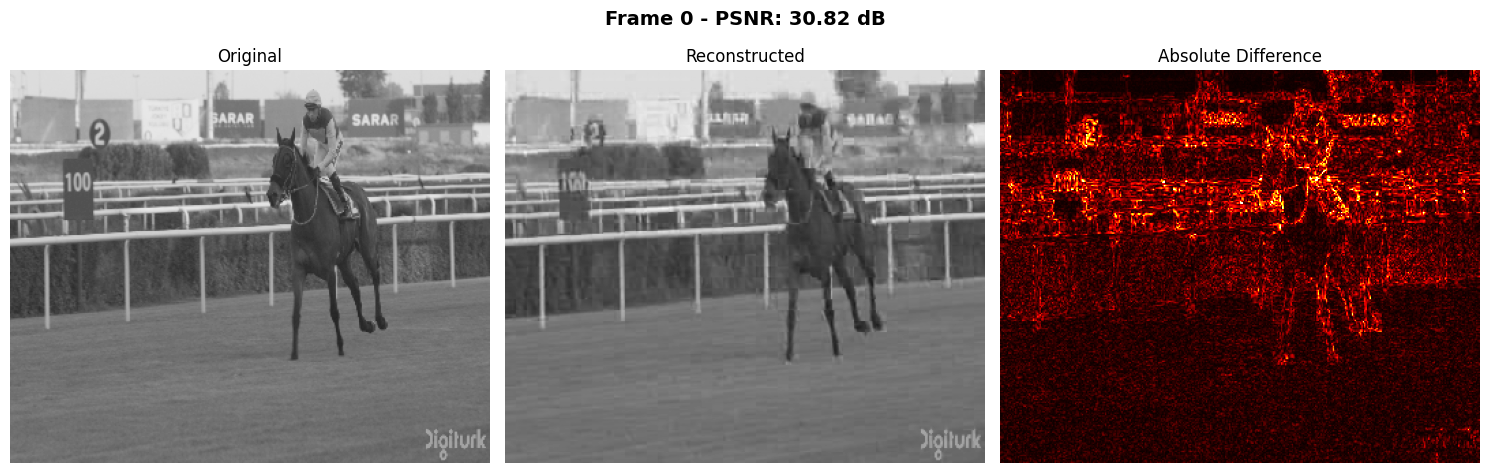

In [45]:
# Select test frame
test_frame_idx = 0
test_frame_y = yuv_frames_processed[test_frame_idx]['Y']

print(f"\n{'='*60}")
print(f"Testing on Frame {test_frame_idx}")
print(f"{'='*60}")

# Partition into blocks
frame_blocks = preprocessor.partition_into_blocks(test_frame_y)
print(f"Frame shape: {test_frame_y.shape}")
print(f"Blocks shape: {frame_blocks.shape}")
print(f"Total blocks: {frame_blocks.shape[0] * frame_blocks.shape[1]}")

# Encode
print("\nEncoding...")
start_time = time.time()
encoded_indices, reconstructed_blocks = rvq_encoder.encode_frame(frame_blocks)
encoding_time = time.time() - start_time

print(f" Encoded in {encoding_time:.2f}s")
print(f"   {len(encoded_indices)} blocks encoded")
print(f"   {len(encoded_indices[0])} indices per block")

# Reconstruct frame
reconstructed_frame = preprocessor.blocks_to_frame(reconstructed_blocks)

# Quality metrics
psnr = compute_psnr(test_frame_y, reconstructed_frame)
print(f"\n Quality Metrics:")
print(f"   PSNR: {psnr:.2f} dB")

# Visualize
visualize_comparison(test_frame_y, reconstructed_frame, f"Frame {test_frame_idx}")

# 12A Adaptive Frame Encoding 

## Serve a extension from baseline


Adaptive RVQ: Testing on Frame 0
 Adaptive encoding time: 49.34s
   1584 blocks encoded

 Adaptive Quality Metrics:
   PSNR: 30.82 dB


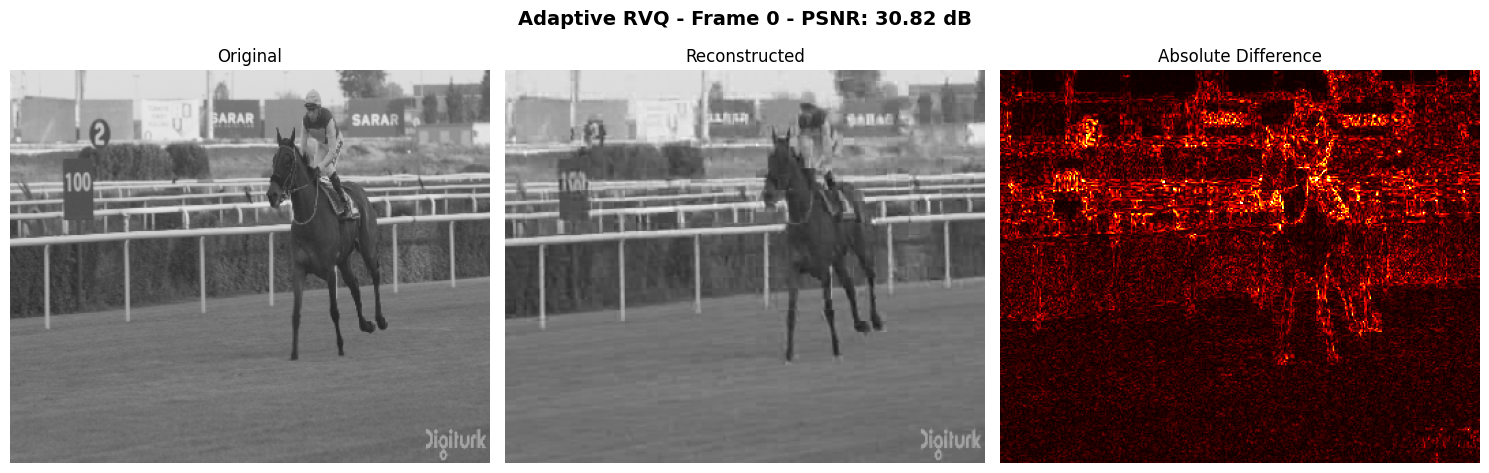

In [46]:
def encode_frame_adaptive(frame_blocks: np.ndarray,
                          encoder: RVQEncoder,
                          rf_model: RandomForestClassifier) -> Tuple[List[List[int]], np.ndarray]:
    """
    Encode all blocks in a frame using adaptive number of stages per block
    predicted by the Random Forest model.
    """
    h_blocks, w_blocks, bs, _ = frame_blocks.shape
    all_indices = []
    reconstructed_blocks = np.zeros_like(frame_blocks, dtype=np.float32)

    for i in range(h_blocks):
        for j in range(w_blocks):
            block = frame_blocks[i, j]

            # 1) compute features
            feats = compute_block_features(block).reshape(1, -1)

            # 2) predict number of stages
            pred_stage = int(rf_model.predict(feats)[0])
            # safety clamp
            pred_stage = max(1, min(pred_stage, encoder.num_stages))

            # 3) encode with that number of stages
            indices, recon_block = encoder.encode_block(block, num_stages=pred_stage)
            all_indices.append(indices)
            reconstructed_blocks[i, j] = recon_block

    return all_indices, reconstructed_blocks


# ---- Test adaptive encoding on the same test frame ----
print(f"\n{'='*60}")
print(f"Adaptive RVQ: Testing on Frame {test_frame_idx}")
print(f"{'='*60}")

frame_blocks = preprocessor.partition_into_blocks(test_frame_y)

start_time = time.time()
encoded_indices_adapt, reconstructed_blocks_adapt = encode_frame_adaptive(
    frame_blocks, rvq_encoder, rf_stage_selector
)
encoding_time_adapt = time.time() - start_time

print(f" Adaptive encoding time: {encoding_time_adapt:.2f}s")
print(f"   {len(encoded_indices_adapt)} blocks encoded")

# Reconstruct frame
reconstructed_frame_adapt = preprocessor.blocks_to_frame(reconstructed_blocks_adapt)

# Quality metrics
psnr_adapt = compute_psnr(test_frame_y, reconstructed_frame_adapt)
print(f"\n Adaptive Quality Metrics:")
print(f"   PSNR: {psnr_adapt:.2f} dB")

# Visualize
visualize_comparison(test_frame_y, reconstructed_frame_adapt, 
                     f"Adaptive RVQ - Frame {test_frame_idx}")


## 13. Apply Entropy Coding

In [47]:
# Flatten all indices
all_indices = []
for block_indices in encoded_indices:
    all_indices.extend(block_indices)

print(f"\n{'='*60}")
print("Entropy Coding")
print(f"{'='*60}")
print(f"Total indices: {len(all_indices)}")

# Huffman coding
huffman_coder = HuffmanCoder()
encoded_bitstring = huffman_coder.encode(all_indices)

# Compression statistics
original_bits = len(all_indices) * 8
compressed_bits = len(encoded_bitstring)
compression_ratio_huffman = original_bits / compressed_bits

print(f"\n Compression Statistics:")
print(f"   Original (indices): {original_bits} bits ({original_bits/8000:.2f} KB)")
print(f"   Compressed (Huffman): {compressed_bits} bits ({compressed_bits/8000:.2f} KB)")
print(f"   Huffman compression: {compression_ratio_huffman:.2f}x")

# Overall compression
original_frame_bits = test_frame_y.size * 8
overall_compression = original_frame_bits / compressed_bits

print(f"\n Overall Frame Compression:")
print(f"   Original frame: {original_frame_bits} bits ({original_frame_bits/8000:.2f} KB)")
print(f"   Compressed: {compressed_bits} bits ({compressed_bits/8000:.2f} KB)")
print(f"   Overall ratio: {overall_compression:.2f}x")

# Bitrate estimation
bitrate_kbps = (compressed_bits * FPS) / 1000
print(f"   Estimated bitrate: {bitrate_kbps:.2f} kbps (at {FPS} fps)")


Entropy Coding
Total indices: 4752

Huffman coding:
  Unique symbols: 253
  Avg code length: 7.26 bits

 Compression Statistics:
   Original (indices): 38016 bits (4.75 KB)
   Compressed (Huffman): 34493 bits (4.31 KB)
   Huffman compression: 1.10x

 Overall Frame Compression:
   Original frame: 811008 bits (101.38 KB)
   Compressed: 34493 bits (4.31 KB)
   Overall ratio: 23.51x
   Estimated bitrate: 4139.16 kbps (at 120 fps)


## 14. Process All Frames

In [48]:
print(f"\n{'='*60}")
print(f"Processing All {len(yuv_frames_processed)} Frames")
print(f"{'='*60}\n")

results = []

for frame_idx in tqdm(range(len(yuv_frames_processed)), desc="Processing frames"):
    frame_y = yuv_frames_processed[frame_idx]['Y']
    
    # Encode
    frame_blocks = preprocessor.partition_into_blocks(frame_y)
    encoded_indices, reconstructed_blocks = rvq_encoder.encode_frame(frame_blocks)
    reconstructed_frame = preprocessor.blocks_to_frame(reconstructed_blocks)
    
    # Quality
    psnr = compute_psnr(frame_y, reconstructed_frame)
    
    # Entropy coding
    all_indices = []
    for block_indices in encoded_indices:
        all_indices.extend(block_indices)
    
    # Build Huffman tree if first frame
    if frame_idx == 0:
        huffman_coder_all = HuffmanCoder()
        huffman_coder_all.build_huffman_tree(all_indices)
    
    encoded_bitstring = huffman_coder_all.encode(all_indices)
    
    # Statistics
    original_bits = frame_y.size * 8
    compressed_bits = len(encoded_bitstring)
    compression_ratio = original_bits / compressed_bits
    bitrate = (compressed_bits * FPS) / 1000
    
    results.append({
        'frame': frame_idx,
        'psnr': psnr,
        'original_bits': original_bits,
        'compressed_bits': compressed_bits,
        'compression_ratio': compression_ratio,
        'bitrate_kbps': bitrate
    })

print(f"\n Processed {len(results)} frames")


Processing All 100 Frames



Processing frames:   1%|          | 1/100 [00:00<00:11,  8.44it/s]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.26 bits


Processing frames: 100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


 Processed 100 frames


## 15. Results Summary

In [49]:
import pandas as pd
results_filename = f"results/{VIDEO_NAME}_results_s{NUM_STAGES}_c{CODEBOOK_SIZE}.csv"
os.makedirs(os.path.dirname(results_filename), exist_ok=True)

# Create results dataframe
df_results = pd.DataFrame(results)

print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}\n")

print("Per-Frame Results:")
print(df_results.to_string(index=False))

print(f"\n{'='*60}")
print("AVERAGE METRICS")
print(f"{'='*60}")
print(f"Average PSNR: {df_results['psnr'].mean():.2f} dB")
print(f"Min PSNR: {df_results['psnr'].min():.2f} dB")
print(f"Max PSNR: {df_results['psnr'].max():.2f} dB")
print(f"\nAverage Compression Ratio: {df_results['compression_ratio'].mean():.2f}x")
print(f"Average Bitrate: {df_results['bitrate_kbps'].mean():.2f} kbps")
print(f"\nTotal Original Size: {df_results['original_bits'].sum() / (8*1024):.2f} KB")
print(f"Total Compressed Size: {df_results['compressed_bits'].sum() / (8*1024):.2f} KB")
print(f"Overall Compression: {df_results['original_bits'].sum() / df_results['compressed_bits'].sum():.2f}x")

# Save results

df_results.to_csv(results_filename, index=False)
print(f"\n Results saved: {results_filename}")


RESULTS SUMMARY

Per-Frame Results:
 frame      psnr  original_bits  compressed_bits  compression_ratio  bitrate_kbps
     0 30.817528         811008            34493          23.512249       4139.16
     1 30.839798         811008            34867          23.260045       4184.04
     2 30.756268         811008            34893          23.242713       4187.16
     3 30.834829         811008            34803          23.302819       4176.36
     4 30.830090         811008            34778          23.319570       4173.36
     5 30.871845         811008            34826          23.287429       4179.12
     6 30.860994         811008            35017          23.160408       4202.04
     7 30.793633         811008            35010          23.165039       4201.20
     8 30.877716         811008            34857          23.266718       4182.84
     9 30.918854         811008            34926          23.220752       4191.12
    10 30.902727         811008            34820          23.

## 16. Visualization: Rate-Distortion Curve

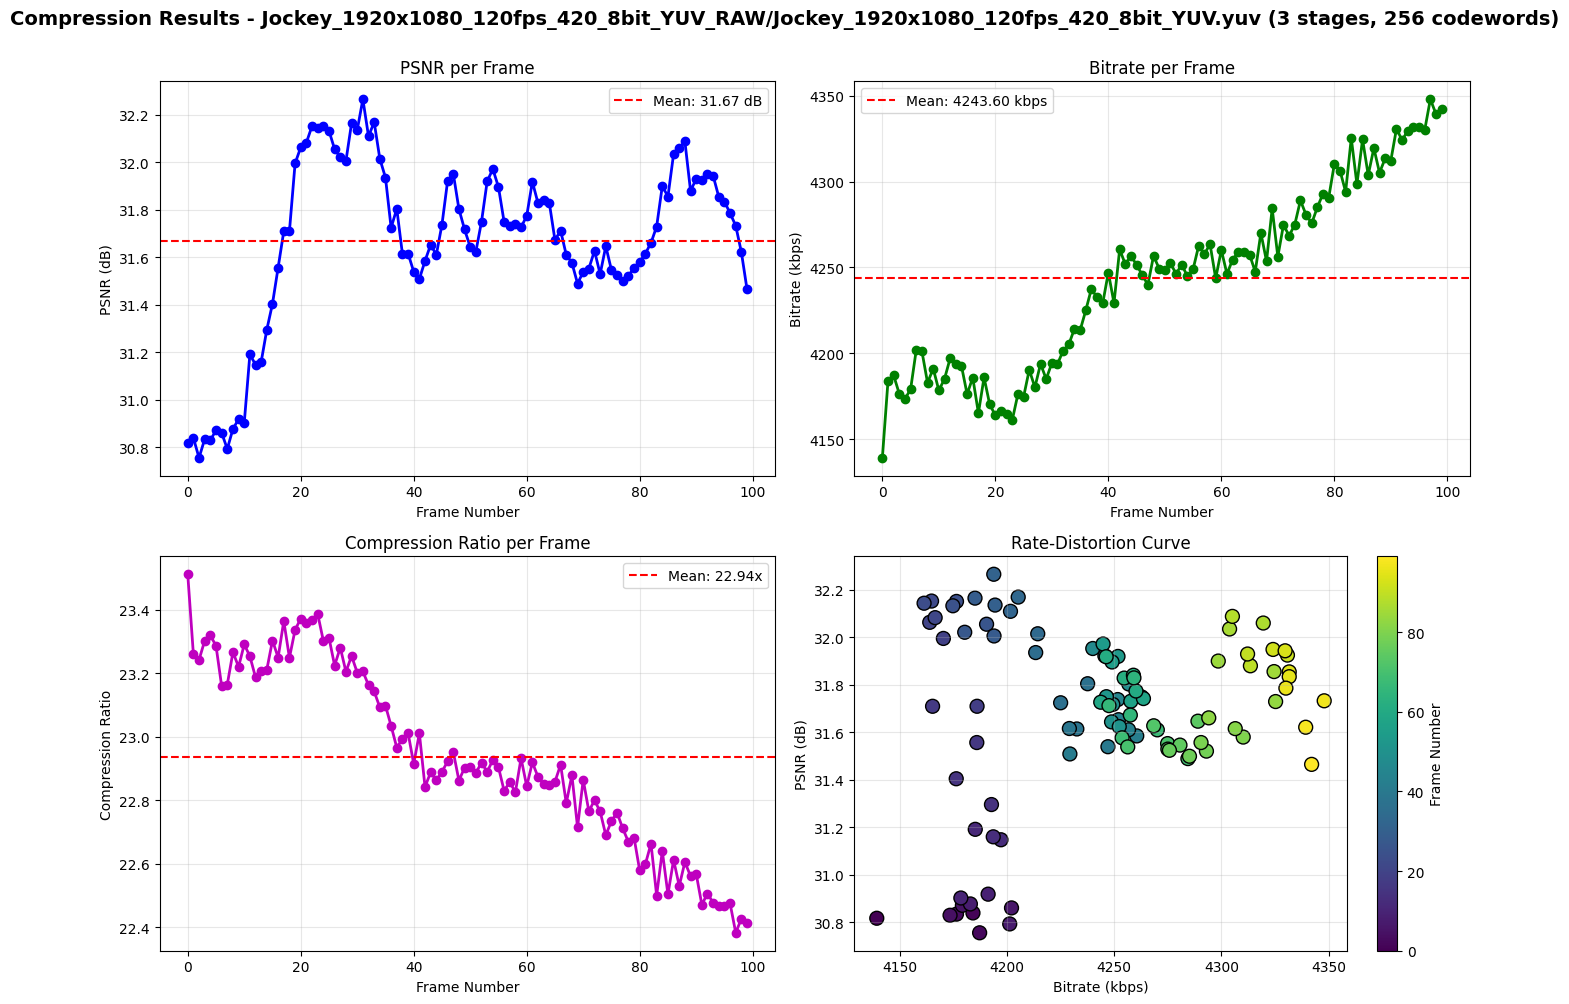

 Plots saved to results/


In [50]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PSNR vs Frame
axes[0, 0].plot(df_results['frame'], df_results['psnr'], 'b-o', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Frame Number')
axes[0, 0].set_ylabel('PSNR (dB)')
axes[0, 0].set_title('PSNR per Frame')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(df_results['psnr'].mean(), color='r', linestyle='--', 
                   label=f"Mean: {df_results['psnr'].mean():.2f} dB")
axes[0, 0].legend()

# Bitrate vs Frame
axes[0, 1].plot(df_results['frame'], df_results['bitrate_kbps'], 'g-o', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Frame Number')
axes[0, 1].set_ylabel('Bitrate (kbps)')
axes[0, 1].set_title('Bitrate per Frame')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(df_results['bitrate_kbps'].mean(), color='r', linestyle='--',
                   label=f"Mean: {df_results['bitrate_kbps'].mean():.2f} kbps")
axes[0, 1].legend()

# Compression Ratio vs Frame
axes[1, 0].plot(df_results['frame'], df_results['compression_ratio'], 'm-o', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Frame Number')
axes[1, 0].set_ylabel('Compression Ratio')
axes[1, 0].set_title('Compression Ratio per Frame')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(df_results['compression_ratio'].mean(), color='r', linestyle='--',
                   label=f"Mean: {df_results['compression_ratio'].mean():.2f}x")
axes[1, 0].legend()

# Rate-Distortion (PSNR vs Bitrate)
axes[1, 1].scatter(df_results['bitrate_kbps'], df_results['psnr'], 
                   c=df_results['frame'], cmap='viridis', s=100, edgecolors='black')
axes[1, 1].set_xlabel('Bitrate (kbps)')
axes[1, 1].set_ylabel('PSNR (dB)')
axes[1, 1].set_title('Rate-Distortion Curve')
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Frame Number')

plt.suptitle(f'Compression Results - {VIDEO_NAME} ({NUM_STAGES} stages, {CODEBOOK_SIZE} codewords)',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f'results/{VIDEO_NAME}_plots_s{NUM_STAGES}_c{CODEBOOK_SIZE}.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print(f" Plots saved to results/")

## 17. Visual Comparison: Multiple Frames

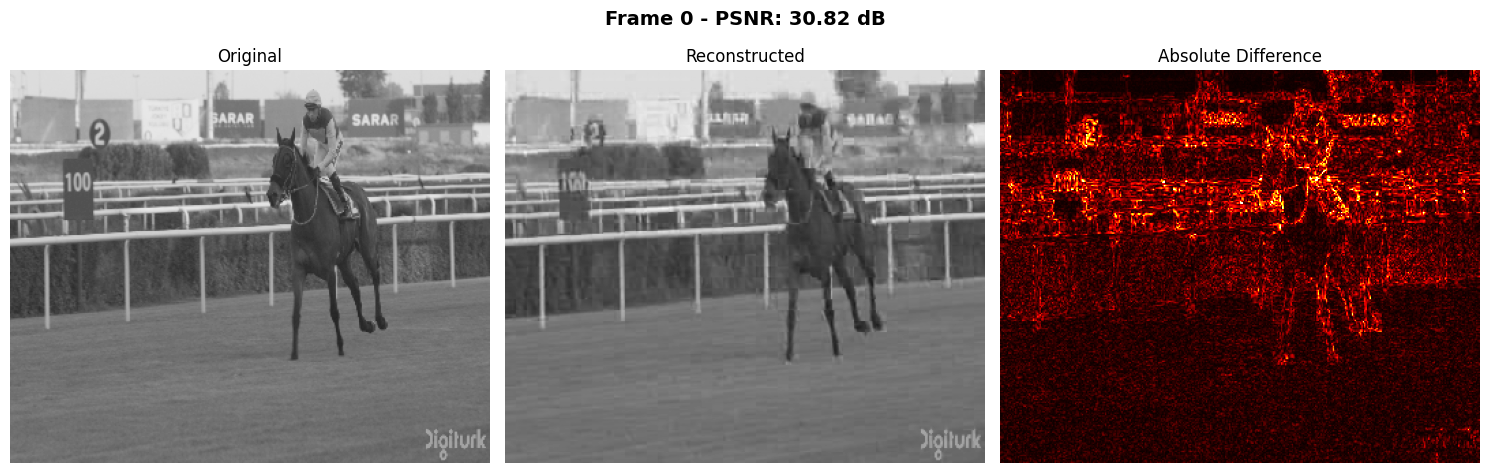

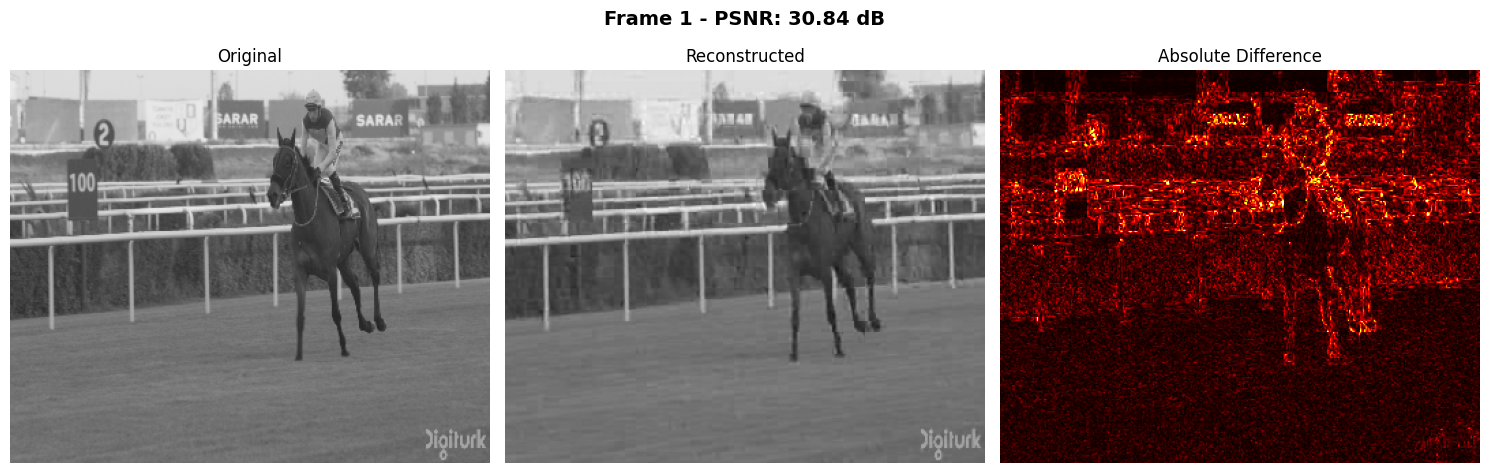

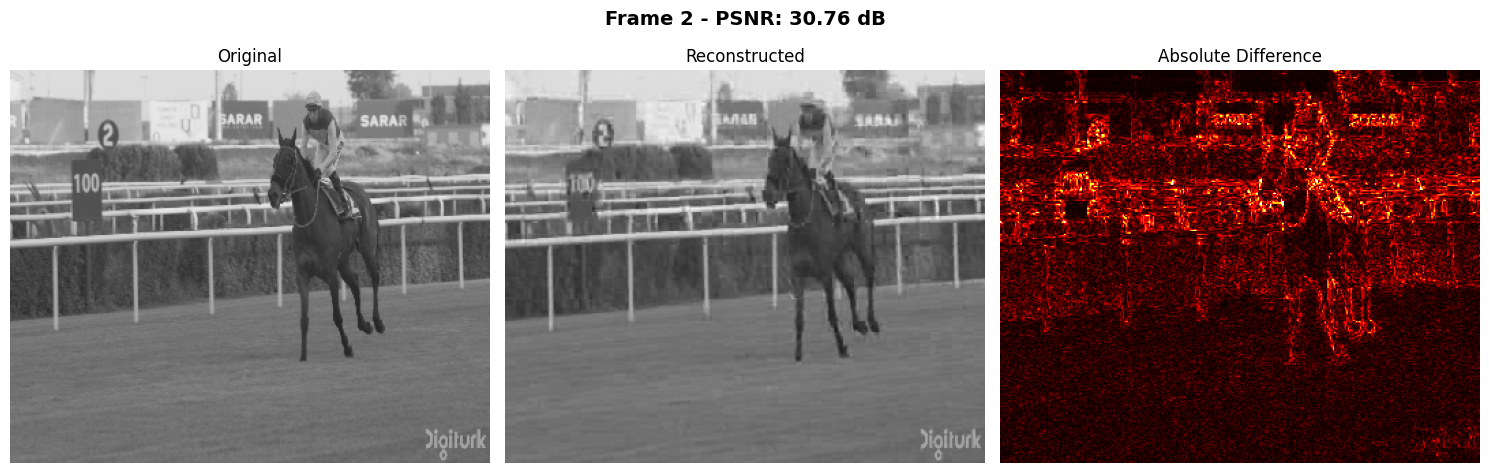

In [51]:
# Show comparison for first few frames
num_frames_to_show = min(3, len(yuv_frames_processed))

for i in range(num_frames_to_show):
    frame_y = yuv_frames_processed[i]['Y']
    frame_blocks = preprocessor.partition_into_blocks(frame_y)
    _, reconstructed_blocks = rvq_encoder.encode_frame(frame_blocks)
    reconstructed_frame = preprocessor.blocks_to_frame(reconstructed_blocks)
    
    visualize_comparison(frame_y, reconstructed_frame, f"Frame {i}")

# 18. Reconstruct Video

In [55]:
# Note this takes a while

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_orig = cv2.VideoWriter('results/original_y.mp4', fourcc, FPS, TARGET_RESOLUTION, isColor=False)
out_base = cv2.VideoWriter('results/RVQ (kmeans)_y.mp4', fourcc, FPS, TARGET_RESOLUTION, isColor=False)
out_adap = cv2.VideoWriter('results/adaptive RVQ (RF & KM)_y.mp4', fourcc, FPS, TARGET_RESOLUTION, isColor=False)

print("\nWriting videos (this will re-encode frames)...")

for frame_idx in tqdm(range(len(yuv_frames_processed)), desc="Writing videos"):
    # Keep a uint8 version for writing to video
    frame_y_uint8 = yuv_frames_processed[frame_idx]['Y'].astype(np.uint8)
    
    # Use float32 for RVQ processing to avoid uint8/float32 ufunc errors
    frame_y = frame_y_uint8.astype(np.float32)
    
    # Partition into blocks (now float32)
    frame_blocks = preprocessor.partition_into_blocks(frame_y)
    
    # Baseline RVQ reconstruction (works in float32 internally)
    _, recon_blocks_base = rvq_encoder.encode_frame(frame_blocks)
    recon_frame_base = preprocessor.blocks_to_frame(recon_blocks_base)
    recon_frame_base = np.clip(recon_frame_base, 0, 255).astype(np.uint8)
    
    # Adaptive RVQ reconstruction (also on float32 blocks)
    _, recon_blocks_adap = encode_frame_adaptive(frame_blocks, rvq_encoder, rf_stage_selector)
    recon_frame_adap = preprocessor.blocks_to_frame(recon_blocks_adap)
    recon_frame_adap = np.clip(recon_frame_adap, 0, 255).astype(np.uint8)
    
    # Write frames (grayscale expected as single-channel uint8 images)
    out_orig.write(frame_y_uint8)
    out_base.write(recon_frame_base)
    out_adap.write(recon_frame_adap)

out_orig.release()
out_base.release()
out_adap.release()

print("Saved:")
print("  results/original_y.mp4")
print("  results/RVQ (kmeans)_y.mp4")
print("  results/adaptive RVQ (RF & KM)y.mp4")



Writing videos (this will re-encode frames)...


Writing videos: 100%|██████████| 100/100 [1:34:32<00:00, 56.72s/it]

Saved:
  results/original_y.mp4
  results/RVQ (kmeans)_y.mp4
  results/adaptive RVQ (RF & KM)y.mp4


# 19. Compare Results

In [56]:

import pandas as pd
import numpy as np

# 1. Gather results from df_results (already exists)

metrics = {
    'System': 'RVQ',
    'Codebook Init': 'K-means++',
    'Adaptive Stage': 'No',
    'Avg PSNR (dB)': round(df_results['psnr'].mean(), 2),
    'Bitrate (kbps)': round(df_results['bitrate_kbps'].mean(), 2),
    'Compression Ratio': round(df_results['compression_ratio'].mean(), 2)
}


# 2. Run Adaptive system on all frames 

adaptive_results = []

print("\nRunning Adaptive RVQ over all frames...")
for frame_idx in tqdm(range(len(yuv_frames_processed)), desc="Adaptive frames"):
    frame_y = yuv_frames_processed[frame_idx]['Y']
    frame_blocks = preprocessor.partition_into_blocks(frame_y)
    
    encoded_indices, reconstructed_blocks = encode_frame_adaptive(
        frame_blocks, rvq_encoder, rf_stage_selector
    )
    recon_frame = preprocessor.blocks_to_frame(reconstructed_blocks)
    psnr = compute_psnr(frame_y, recon_frame)

    # Flatten indices for entropy coding
    all_indices = []
    for block_indices in encoded_indices:
        all_indices.extend(block_indices)

    # Huffman coding
    huffman_coder_adap = HuffmanCoder()
    encoded_bitstring = huffman_coder_adap.encode(all_indices)

    # Metrics
    original_bits = frame_y.size * 8
    compressed_bits = len(encoded_bitstring)
    compression_ratio = original_bits / compressed_bits
    bitrate = (compressed_bits * FPS) / 1000

    adaptive_results.append({
        'frame': frame_idx,
        'psnr': psnr,
        'bitrate_kbps': bitrate,
        'compression_ratio': compression_ratio
    })

df_adaptive = pd.DataFrame(adaptive_results)


# 3. Compute averages for adaptive system
adaptive_metrics = {
    'System': 'Adaptive RVQ',
    'Codebook Init': 'K-means++',
    'Adaptive Stage': 'Random Forest',
    'Avg PSNR (dB)': round(df_adaptive['psnr'].mean(), 2),
    'Bitrate (kbps)': round(df_adaptive['bitrate_kbps'].mean(), 2),
    'Compression Ratio': round(df_adaptive['compression_ratio'].mean(), 2)
}


# 4. Combine and include Original (uncompressed) reference
original_metrics = {
    'System': 'Original (Uncompressed)',
    'Codebook Init': '-',
    'Adaptive Stage': '-',
    'Avg PSNR (dB)': '∞',
    'Bitrate (kbps)': '-',
    'Compression Ratio': 1.00
}

comparison_df = pd.DataFrame([original_metrics, metrics, adaptive_metrics])


# 5. Display 

print(comparison_df.to_string(index=False, justify='center'))

# Save for report
comparison_df.to_csv('results/comparison_summary.csv', index=False)
print("\nSaved comparison summary to results/comparison_summary.csv")



Running Adaptive RVQ over all frames...


Adaptive frames:   1%|          | 1/100 [00:57<1:35:40, 57.98s/it]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.28 bits


Adaptive frames:   2%|▏         | 2/100 [01:56<1:35:00, 58.16s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.30 bits


Adaptive frames:   3%|▎         | 3/100 [02:53<1:33:16, 57.69s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.30 bits


Adaptive frames:   4%|▍         | 4/100 [03:51<1:32:23, 57.75s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.30 bits


Adaptive frames:   5%|▌         | 5/100 [04:47<1:30:40, 57.26s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.29 bits


Adaptive frames:   6%|▌         | 6/100 [05:45<1:30:15, 57.61s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.29 bits


Adaptive frames:   7%|▋         | 7/100 [06:44<1:29:45, 57.91s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.32 bits


Adaptive frames:   8%|▊         | 8/100 [07:42<1:28:45, 57.88s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.30 bits


Adaptive frames:   9%|▉         | 9/100 [08:40<1:27:49, 57.90s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.29 bits


Adaptive frames:  10%|█         | 10/100 [09:33<1:24:51, 56.57s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.30 bits


Adaptive frames:  11%|█         | 11/100 [10:15<1:17:20, 52.14s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.28 bits


Adaptive frames:  12%|█▏        | 12/100 [10:59<1:12:38, 49.53s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.30 bits


Adaptive frames:  13%|█▎        | 13/100 [11:42<1:08:52, 47.50s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.32 bits


Adaptive frames:  14%|█▍        | 14/100 [12:26<1:06:47, 46.60s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.30 bits


Adaptive frames:  15%|█▌        | 15/100 [13:07<1:03:37, 44.92s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.29 bits


Adaptive frames:  16%|█▌        | 16/100 [14:00<1:06:12, 47.29s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.28 bits


Adaptive frames:  17%|█▋        | 17/100 [14:59<1:10:06, 50.68s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.27 bits


Adaptive frames:  18%|█▊        | 18/100 [15:57<1:12:13, 52.84s/it]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.23 bits


Adaptive frames:  19%|█▉        | 19/100 [16:55<1:13:28, 54.42s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.28 bits


Adaptive frames:  20%|██        | 20/100 [17:52<1:13:42, 55.28s/it]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.26 bits


Adaptive frames:  21%|██        | 21/100 [18:50<1:13:47, 56.04s/it]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.25 bits


Adaptive frames:  22%|██▏       | 22/100 [19:48<1:13:33, 56.59s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.25 bits


Adaptive frames:  23%|██▎       | 23/100 [20:46<1:13:19, 57.14s/it]


Huffman coding:
  Unique symbols: 251
  Avg code length: 7.24 bits


Adaptive frames:  24%|██▍       | 24/100 [21:44<1:12:41, 57.39s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.25 bits


Adaptive frames:  25%|██▌       | 25/100 [22:41<1:11:42, 57.36s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.26 bits


Adaptive frames:  26%|██▌       | 26/100 [23:40<1:11:10, 57.70s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.26 bits


Adaptive frames:  27%|██▋       | 27/100 [24:38<1:10:16, 57.76s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.29 bits


Adaptive frames:  28%|██▊       | 28/100 [25:36<1:09:33, 57.96s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.25 bits


Adaptive frames:  29%|██▉       | 29/100 [26:35<1:08:52, 58.21s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.30 bits


Adaptive frames:  30%|███       | 30/100 [27:33<1:07:52, 58.18s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.28 bits


Adaptive frames:  31%|███       | 31/100 [28:31<1:06:52, 58.15s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.30 bits


Adaptive frames:  32%|███▏      | 32/100 [29:29<1:05:53, 58.14s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.29 bits


Adaptive frames:  33%|███▎      | 33/100 [30:28<1:05:05, 58.28s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.30 bits


Adaptive frames:  34%|███▍      | 34/100 [31:26<1:04:13, 58.39s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.31 bits


Adaptive frames:  35%|███▌      | 35/100 [32:24<1:03:07, 58.26s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.34 bits


Adaptive frames:  36%|███▌      | 36/100 [33:23<1:02:05, 58.21s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.32 bits


Adaptive frames:  37%|███▋      | 37/100 [34:21<1:01:16, 58.36s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.35 bits


Adaptive frames:  38%|███▊      | 38/100 [35:20<1:00:22, 58.43s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.35 bits


Adaptive frames:  39%|███▉      | 39/100 [36:19<59:31, 58.55s/it]  


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.36 bits


Adaptive frames:  40%|████      | 40/100 [37:17<58:37, 58.63s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.34 bits


Adaptive frames:  41%|████      | 41/100 [38:13<56:44, 57.70s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.35 bits


Adaptive frames:  42%|████▏     | 42/100 [39:09<55:24, 57.32s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.35 bits


Adaptive frames:  43%|████▎     | 43/100 [40:08<54:45, 57.65s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.37 bits


Adaptive frames:  44%|████▍     | 44/100 [41:07<54:07, 57.99s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.35 bits


Adaptive frames:  45%|████▌     | 45/100 [42:05<53:20, 58.19s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.37 bits


Adaptive frames:  46%|████▌     | 46/100 [43:03<52:16, 58.09s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.38 bits


Adaptive frames:  47%|████▋     | 47/100 [44:01<51:18, 58.08s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.37 bits


Adaptive frames:  48%|████▊     | 48/100 [45:00<50:36, 58.39s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.36 bits


Adaptive frames:  49%|████▉     | 49/100 [45:59<49:40, 58.44s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.38 bits


Adaptive frames:  50%|█████     | 50/100 [46:58<48:45, 58.51s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.35 bits


Adaptive frames:  51%|█████     | 51/100 [47:57<47:54, 58.66s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.37 bits


Adaptive frames:  52%|█████▏    | 52/100 [48:47<44:56, 56.17s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.37 bits


Adaptive frames:  53%|█████▎    | 53/100 [49:28<40:26, 51.63s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.37 bits


Adaptive frames:  54%|█████▍    | 54/100 [50:09<37:05, 48.39s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.36 bits


Adaptive frames:  55%|█████▌    | 55/100 [50:53<35:16, 47.02s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.36 bits


Adaptive frames:  56%|█████▌    | 56/100 [51:35<33:27, 45.62s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.35 bits


Adaptive frames:  57%|█████▋    | 57/100 [52:18<32:12, 44.94s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.38 bits


Adaptive frames:  58%|█████▊    | 58/100 [53:17<34:17, 48.98s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.37 bits


Adaptive frames:  59%|█████▉    | 59/100 [54:15<35:26, 51.86s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.36 bits


Adaptive frames:  60%|██████    | 60/100 [55:13<35:43, 53.59s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.34 bits


Adaptive frames:  61%|██████    | 61/100 [56:11<35:41, 54.90s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.38 bits


Adaptive frames:  62%|██████▏   | 62/100 [57:10<35:31, 56.10s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.36 bits


Adaptive frames:  63%|██████▎   | 63/100 [58:08<35:01, 56.80s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.36 bits


Adaptive frames:  64%|██████▍   | 64/100 [59:03<33:42, 56.18s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.37 bits


Adaptive frames:  65%|██████▌   | 65/100 [59:48<30:47, 52.77s/it]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.36 bits


Adaptive frames:  66%|██████▌   | 66/100 [1:00:30<28:02, 49.49s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.37 bits


Adaptive frames:  67%|██████▋   | 67/100 [1:01:13<26:11, 47.61s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.35 bits


Adaptive frames:  68%|██████▊   | 68/100 [1:01:53<24:15, 45.48s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.37 bits


Adaptive frames:  69%|██████▉   | 69/100 [1:02:36<23:00, 44.53s/it]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.36 bits


Adaptive frames:  70%|███████   | 70/100 [1:03:25<22:59, 45.98s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.40 bits


Adaptive frames:  71%|███████   | 71/100 [1:04:23<23:55, 49.50s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.38 bits


Adaptive frames:  72%|███████▏  | 72/100 [1:05:20<24:15, 51.97s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.39 bits


Adaptive frames:  73%|███████▎  | 73/100 [1:06:16<23:52, 53.06s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.38 bits


Adaptive frames:  74%|███████▍  | 74/100 [1:07:11<23:13, 53.60s/it]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.39 bits


Adaptive frames:  75%|███████▌  | 75/100 [1:08:08<22:43, 54.54s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.40 bits


Adaptive frames:  76%|███████▌  | 76/100 [1:09:05<22:11, 55.48s/it]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.38 bits


Adaptive frames:  77%|███████▋  | 77/100 [1:10:03<21:30, 56.12s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.38 bits


Adaptive frames:  78%|███████▊  | 78/100 [1:11:01<20:49, 56.78s/it]


Huffman coding:
  Unique symbols: 253
  Avg code length: 7.40 bits


Adaptive frames:  79%|███████▉  | 79/100 [1:11:59<19:59, 57.11s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.42 bits


Adaptive frames:  80%|████████  | 80/100 [1:12:57<19:08, 57.41s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.41 bits


Adaptive frames:  81%|████████  | 81/100 [1:13:56<18:16, 57.72s/it]


Huffman coding:
  Unique symbols: 252
  Avg code length: 7.43 bits


Adaptive frames:  82%|████████▏ | 82/100 [1:14:54<17:20, 57.81s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.42 bits


Adaptive frames:  83%|████████▎ | 83/100 [1:15:52<16:24, 57.93s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.41 bits


Adaptive frames:  84%|████████▍ | 84/100 [1:16:51<15:29, 58.12s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.43 bits


Adaptive frames:  85%|████████▌ | 85/100 [1:17:49<14:31, 58.11s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.40 bits


Adaptive frames:  86%|████████▌ | 86/100 [1:18:47<13:34, 58.16s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.42 bits


Adaptive frames:  87%|████████▋ | 87/100 [1:19:45<12:36, 58.16s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.40 bits


Adaptive frames:  88%|████████▊ | 88/100 [1:20:43<11:37, 58.11s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.42 bits


Adaptive frames:  89%|████████▉ | 89/100 [1:21:41<10:39, 58.12s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.40 bits


Adaptive frames:  90%|█████████ | 90/100 [1:22:40<09:43, 58.32s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.42 bits


Adaptive frames:  91%|█████████ | 91/100 [1:23:38<08:44, 58.29s/it]


Huffman coding:
  Unique symbols: 254
  Avg code length: 7.41 bits


Adaptive frames:  92%|█████████▏| 92/100 [1:24:37<07:46, 58.32s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.41 bits


Adaptive frames:  93%|█████████▎| 93/100 [1:25:35<06:49, 58.48s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.42 bits


Adaptive frames:  94%|█████████▍| 94/100 [1:26:34<05:51, 58.65s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.41 bits


Adaptive frames:  95%|█████████▌| 95/100 [1:27:32<04:51, 58.37s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.42 bits


Adaptive frames:  96%|█████████▌| 96/100 [1:28:29<03:51, 57.98s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.41 bits


Adaptive frames:  97%|█████████▋| 97/100 [1:29:28<02:54, 58.22s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.42 bits


Adaptive frames:  98%|█████████▊| 98/100 [1:30:17<01:50, 55.37s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.43 bits


Adaptive frames:  99%|█████████▉| 99/100 [1:31:01<00:51, 51.93s/it]


Huffman coding:
  Unique symbols: 256
  Avg code length: 7.44 bits


Adaptive frames: 100%|██████████| 100/100 [1:32:11<00:00, 55.32s/it]


Huffman coding:
  Unique symbols: 255
  Avg code length: 7.44 bits
         System         Codebook Init Adaptive Stage Avg PSNR (dB) Bitrate (kbps)  Compression Ratio
Original (Uncompressed)           -               -           ∞              -           1.00       
                    RVQ   K-means++              No       31.67         4243.6          22.94       
           Adaptive RVQ   K-means++   Random Forest       31.67        4141.29          23.50       

Saved comparison summary to results/comparison_summary.csv
